In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import time
import sys

sys.path.append(os.path.abspath(".."))   # Add root path to sys.path
os.chdir("..")  # Change working directory to root path

from src.preprocessing import read_image, windy_preprocessing_pipeline
from tqdm import tqdm
from datetime import datetime

sys.path


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



['/opt/anaconda3/envs/cv_env/lib/python312.zip',
 '/opt/anaconda3/envs/cv_env/lib/python3.12',
 '/opt/anaconda3/envs/cv_env/lib/python3.12/lib-dynload',
 '',
 '/opt/anaconda3/envs/cv_env/lib/python3.12/site-packages',
 '/Users/tranquochieu/Documents/NCKH/Weather forecasting/code (new - 251)']

### Load data first

In [2]:
from src.preprocessing import read_numpy_grid, nexrad_numpy_preprocessing_pipeline
from tqdm import tqdm

data_name = "KGRR"
SOURCE_PATH = f"data/numpy_grid/{data_name}"

img_paths = [
    os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.npy')
]

img_shape = read_numpy_grid(img_paths[0]).shape       # get shape of the image

print(f"Image shape: {img_shape}")
print(f"-" * 20)

time_frames = []
dbz_maps = []

for path in tqdm(img_paths, desc="Processing images and detecting storms"):
    file_name = path.split("/")[-1].split(".")[0]
    # time_frames.append(datetime.strptime(file_name[:-4], '%Y%m%d-%H%M%S'))       # Get file name without extension
    time_frames.append(datetime.strptime(file_name[4:19], "%Y%m%d_%H%M%S"))       # Get file name without extension
    img = read_numpy_grid(path)
    dbz_maps.append(nexrad_numpy_preprocessing_pipeline(img))

FIRST_TIME_FRAME = time_frames[0]

print(f"Number of frames: {len(dbz_maps)}")

Image shape: (901, 901)
--------------------


Processing images and detecting storms: 100%|██████████| 31/31 [00:00<00:00, 223.13it/s]

Number of frames: 31


In [3]:
# file_name = "philippines_13.269_123.832"

# SOURCE_PATH = f"data/image_old/{file_name}"

# img_paths = [
#     os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')
# ][:50]

# img_shape = read_image(img_paths[0]).shape       # get shape of the image
# print(f"Image shape: {img_shape}")
# print(f"-" * 20)

# time_frames = []
# dbz_maps = []       

# for path in tqdm(img_paths, desc="Processing images and detecting storms"):
#     time_frames.append(datetime.strptime(os.path.basename(path).split('/')[0][:-4], '%Y%m%d-%H%M%S'))       # Get file name without extension
#     img = read_image(path)
#     dbz_maps.append(windy_preprocessing_pipeline(img))

# print(f"Number of frames: {len(dbz_maps)}")

In [4]:
# replace nan values with 0
for i in range(len(dbz_maps)):
    dbz_maps[i] = np.nan_to_num(dbz_maps[i], nan=0.0)

(dbz_maps[0] > 0).sum()

np.int64(154048)

## Load model

In [5]:
from src.models import STitanPrecipitationModel
from src.identification import HypothesisIdentifier
from src.cores.base import StormsMap

model = STitanPrecipitationModel(identifier=HypothesisIdentifier())

storms_maps: list[StormsMap] = []
total_storms = 0
DENSITY = 0.05  # particle density

pbar = tqdm(zip(dbz_maps, time_frames), total=len(dbz_maps), desc="Detecting storms")
for idx, (dbz_map, time_frame) in enumerate(pbar):
    storms_map = model.identify_storms(
        dbz_map, time_frame, map_id=f"time_{idx}", threshold=35, filter_area=50, particle_density=DENSITY
    )
    total_storms += len(storms_map.storms)
    pbar.set_postfix({"Total storms detected": total_storms})

    storms_maps.append(storms_map)

Detecting storms: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it, Total storms detected=1465]


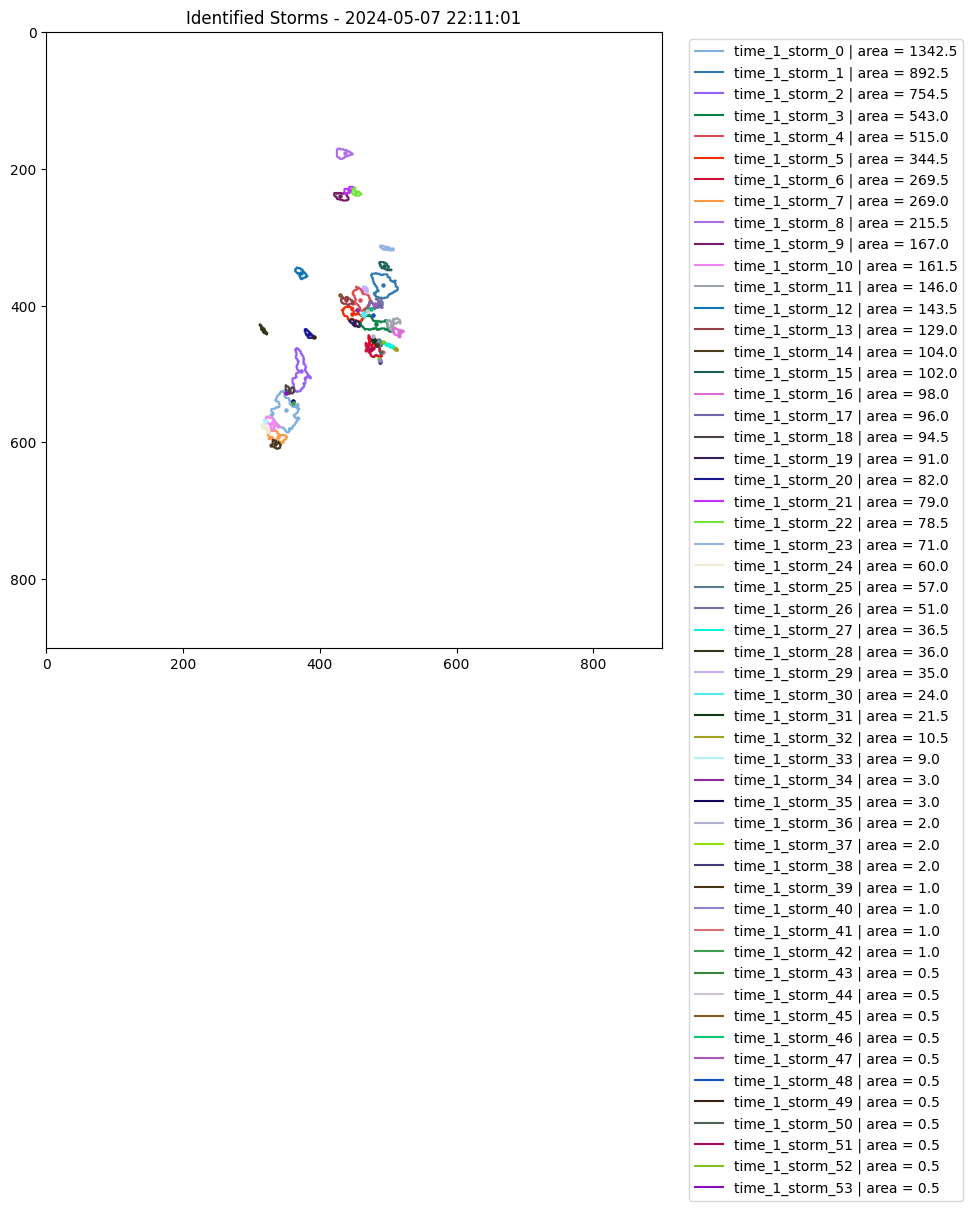

In [6]:
from src.preprocessing import convert_polygons_to_contours

# Visualize storms with contours on the first DBZ map
storms_map = storms_maps[1]
plt.figure(figsize=(10, 8))

img_shape = dbz_maps[0].shape
img_shape = (img_shape[0], img_shape[1], 3)
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

# colors = spectral_colors(len(storms_map.storms))

for storm in storms_map.storms:
    y_centroid, x_centroid = storm.centroid
    color = storm.contour_color
    
    plt.plot([], [], color=np.array(color)/255.0, label=f"{storm.id} | area = {storm.contour.area:.1f}")
    plt.scatter(x_centroid, y_centroid, color=np.array(color)/255.0, s=5)
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, color, thickness=2)  # Draw contour in red

plt.imshow(blank_image, cmap='grey')
plt.title(f"Identified Storms - {storms_map.time_frame}")
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0))

plt.show()

In [14]:
from src.cores.base import StormsMap
from src.cores.metrics import pod_score, far_score, csi_score

class PredictionBenchmarkModel:
    def __init__(self):
        self.pods = []
        self.fars = []
        self.csis = []
        self.actual = []
        self.predicted = []

    def evaluate_predict(self, actual_storms_map: StormsMap, predicted_storms_map: StormsMap):
        self.actual.append(actual_storms_map)
        self.predicted.append(predicted_storms_map)
        self.pods.append(pod_score(actual_storms_map, predicted_storms_map))
        self.fars.append(far_score(actual_storms_map, predicted_storms_map))
        self.csis.append(csi_score(actual_storms_map, predicted_storms_map))

# Create benchmark model
benchmark_model = PredictionBenchmarkModel()
PREDICT_FORWARD_STEPS = 5
SLOW_START_STEPS = 10

model = STitanPrecipitationModel(identifier=HypothesisIdentifier())  # max_velocity in pixels per hour
temp_storm_map = storms_maps

ours_model_evaluation = PredictionBenchmarkModel()
predicted_maps = []
lead_times = []

for i in range(SLOW_START_STEPS):
    model.processing_map(temp_storm_map[i])  # Warm-up phase

for curr_map, future_map in tqdm(list(zip(temp_storm_map[SLOW_START_STEPS:], temp_storm_map[PREDICT_FORWARD_STEPS + SLOW_START_STEPS:])), desc="Predicting precipitation maps"):
    # Predict map using current data
    dt_seconds = (future_map.time_frame - model.storms_maps[-1].time_frame).total_seconds()
    predicted_map = model.forecast(dt_seconds)
    ours_model_evaluation.evaluate_predict(future_map, predicted_map)
    lead_times.append(dt_seconds)

    # Update new map into knowledge
    model.processing_map(curr_map)  # Update model with the current map

print("Our model evaluation:")
print(f"\tAverage POD: {np.mean(ours_model_evaluation.pods):.4f}")
print(f"\tAverage FAR: {np.mean(ours_model_evaluation.fars):.4f}")
print(f"\tAverage CSI: {np.mean(ours_model_evaluation.csis):.4f}")

print(f"\tAverage lead time: {np.mean(lead_times) / 60:.2f} minutes")

Predicting precipitation maps: 100%|██████████| 16/16 [00:27<00:00,  1.75s/it]

Our model evaluation:
	Average POD: 0.1606
	Average FAR: 0.7790
	Average CSI: 0.1054
	Average lead time: 33.87 minutes


# Overall Analyzing on tracking process
In this tracking, I used both of the median duration and linearity error of tracking

Average object consistency score (area change rate): 3.0844


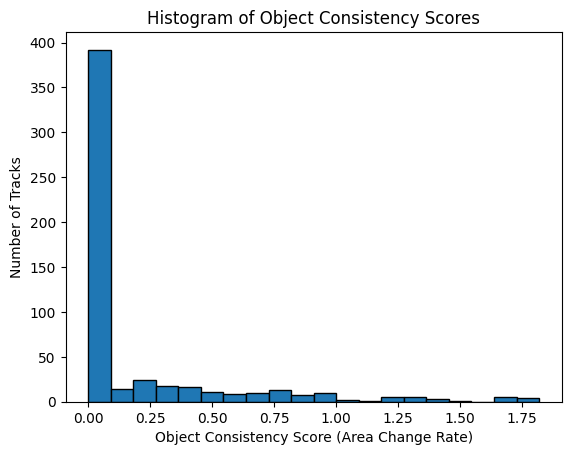

In [8]:
object_consistency_scores = []

for track in model.tracker.tracks:
    areas = [storm.contour.area for storm in track.storms.values()]
    area_changes = [abs(areas[i] - areas[i - 1]) / areas[i - 1] for i in range(1, len(areas)) if areas[i - 1] != 0]
    object_consistency_scores.append(np.mean(area_changes) if area_changes else 0)

object_consistency_scores = np.array(object_consistency_scores)

print(f"Average object consistency score (area change rate): {np.mean(object_consistency_scores):.4f}")

plt.hist(object_consistency_scores[object_consistency_scores < 2], bins=20, edgecolor='black')
plt.title("Histogram of Object Consistency Scores")
plt.xlabel("Object Consistency Score (Area Change Rate)")
plt.ylabel("Number of Tracks")
plt.show()

## B. Mean duration tracking

Median duration of tracking: 2.931740614334471 frames
Maximum duration of tracking: 24 frames
Mean duration of tracking: 2.93 frames


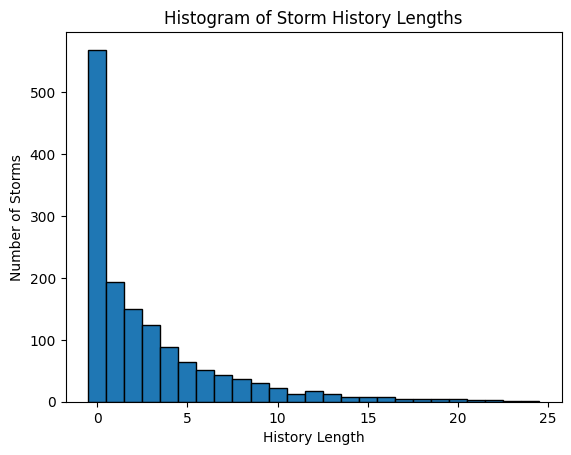

In [9]:
HISTORY_LENGTH_LST = []             # Retrieve history length of all storms

for storms_map in storms_maps:
    for storm in storms_map.storms:
        HISTORY_LENGTH_LST.append(len(storm.history_movements))   # Append history length of each storm

MEDIAN_DURATION = np.mean(HISTORY_LENGTH_LST)

print(f"Median duration of tracking: {MEDIAN_DURATION} frames")
print(f"Maximum duration of tracking: {max(HISTORY_LENGTH_LST)} frames")
print(f"Mean duration of tracking: {np.mean(HISTORY_LENGTH_LST):.2f} frames")

plt.hist(HISTORY_LENGTH_LST, bins=range(0, max(HISTORY_LENGTH_LST) + 2), align='left', edgecolor='black')
plt.title("Histogram of Storm History Lengths")
plt.xlabel("History Length")
plt.ylabel("Number of Storms")
plt.show()

## C. Linearity error tracking
Use linearity to track the different between linear fitting of previous history against the actual matched movement

In [10]:
from src.cores.metrics import linear_tracking_error
import matplotlib.pyplot as plt

# Accumulate linear errors for all storms
LINEAR_ERRORS_LST = []

for storms_map in tqdm(storms_maps, desc="Computing linear fitting errors for storms"):
    for storm in storms_map.storms:
        # If not enough history, skip
        if len(storm.history_movements) <= MEDIAN_DURATION:
            continue

        # Fit linear model
        error_distance = linear_tracking_error(storm.history_movements[:-1]) ** 2      # Final one used for evaluate the movement prediction
        LINEAR_ERRORS_LST.append(error_distance)

print(f"RMSE of linear fitting errors: {np.sqrt(np.mean(LINEAR_ERRORS_LST)):.4f}. Total length: {len(LINEAR_ERRORS_LST)}")

Computing linear fitting errors for storms: 100%|██████████| 31/31 [00:00<00:00, 141.43it/s]

RMSE of linear fitting errors: 56.5784. Total length: 552


In [11]:
import colorsys

def spectral_colors(n: int) -> list[list[int]]:
    colors = []
    for i in range(n):
        # Hue ranges from 0.0 (red) to 0.83 (violet) approximately
        hue = i / max(1, n - 1) * 0.83  
        r, g, b = colorsys.hsv_to_rgb(hue, 1.0, 1.0)
        colors.append([int(r * 255), int(g * 255), int(b * 255)])
    return colors

Processing all storm maps for movement history visualization: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]


----  CURRENT MAP at time 2024-05-08 00:57:09  ----
Storm 0: Number of movement history records: 10
Storm 1: Number of movement history records: 6
Storm 2: Number of movement history records: 15
Storm 3: Number of movement history records: 5
Storm 4: Number of movement history records: 5
Storm 5: Number of movement history records: 4
Storm 6: Number of movement history records: 11
Storm 7: Number of movement history records: 19
Storm 8: Number of movement history records: 24
Storm 9: Number of movement history records: 15
Storm 10: Number of movement history records: 1
Storm 11: Number of movement history records: 5
Storm 12: Number of movement history records: 3
Storm 13: Number of movement history records: 11
Storm 14: Number of movement history records: 2
Storm 15: Number of movement history records: 1
Storm 16: Number of movement history records: 17
Storm 17: Number of movement history records: 11
Storm 18: Number of movement history records: 0
Storm 19: Number of movement history 

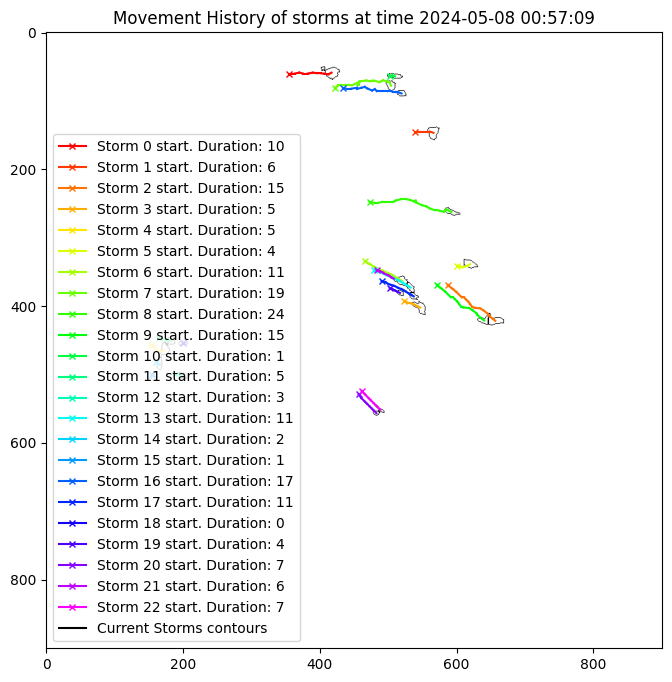

In [12]:
from src.preprocessing import convert_polygons_to_contours

num_maps = len(storms_maps)

model = STitanPrecipitationModel(identifier=HypothesisIdentifier())  # max_velocity in pixels per hour

for i in tqdm(range(num_maps), desc="Processing all storm maps for movement history visualization"):
    model.processing_map(storms_maps[i])  # Warm-up phase

plt.figure(figsize=(8, 8))
blank_img = np.ones(shape=(img_shape[0], img_shape[1], 3), dtype=np.uint8) * 255

current_map = storms_maps[-1]
print(f"----  CURRENT MAP at time {current_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')}  ----")

colors = spectral_colors(len(current_map.storms))

for idx, storm in enumerate(current_map.storms):
    print(f"Storm {idx}: Number of movement history records: {len(storm.history_movements)}")
    current_frame = current_map.time_frame

    color = np.array(colors[idx]) / 255.0
    end_point = (storm.contour.centroid.x, storm.contour.centroid.y)

    # backtrack the movement history
    for move_idx, movement in enumerate(storm.history_movements):
        prev_frame = storms_maps[-(move_idx + 2)].time_frame
        dt = (current_frame - prev_frame).seconds / 3600
        current_frame = prev_frame

        dy, dx = movement[0] * dt, movement[1] * dt

        start = end_point[0] - dx, end_point[1] - dy
        plt.plot([start[0], end_point[0]], [start[1], end_point[1]], color=color)
        end_point = start
    
    plt.plot(end_point[0], end_point[1], marker='x', color=color, markersize=5, label=f'Storm {idx} start. Duration: {len(storm.history_movements)}')

contours = convert_polygons_to_contours([storm.contour for storm in current_map.storms])
cv2.drawContours(blank_img, contours, -1, (0, 0, 0), 1)
plt.plot([], [], color='black', label='Current Storms contours')
plt.title(f"Movement History of storms at time {current_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')}")

plt.imshow(blank_img)
plt.legend()

plt.show()